ibmqfactory.load_account:WARNING:2022-09-20 11:14:29,159: Credentials are already in use. The existing account in the session will be replaced.


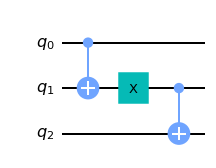

In [5]:
import numpy as np
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import *
import re
import os
import pandas as pd
import itertools
from math import *
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.figure_factory as ff
provider = IBMQ.load_account()

#Value writing function:
def c_value_writer(qubit_n,output): 
    writer = QuantumCircuit(qubit_n)
    for i in range(0,len(output)):
        if output[i] == "1":
            writer.cx(0,i+1)
        elif output[i] == "0":
            writer.cx(0,i+1)
            writer.x(i+1)
    return writer

#Quantum Oracle function:
def create_oracle(qubit_n,answer):
    oracle = QuantumCircuit(qubit_n)
    for x in range(0,len(answer)):
        if answer[x] == "0":
            oracle.cx(x,x+int((qubit_n-1)/2))
            oracle.x(x+int((qubit_n-1)/2))
        elif answer[x] == "1":
            oracle.cx(x,x+int((qubit_n-1)/2))
    clauses = []
    for i in range(int((qubit_n-1)/2),int((qubit_n-1)/2+(qubit_n-1)/2)):
        clauses.append(i)
    oracle.mct(clauses,qubit_n-1)
    return oracle

#Uncomputing function:
def uncompute(qubit_n,answer):
    oracle = QuantumCircuit(qubit_n)
    for x in range(0,len(answer)):
        if answer[x] == "0":
            oracle.cx(x,x+int((qubit_n-1)/2))
            oracle.x(x+int((qubit_n-1)/2))
        elif answer[x] == "1":
            oracle.cx(x,x+int((qubit_n-1)/2))
    return oracle

#Superpositioning function:
def initialize(qubit_n,circuit):
    for i in range(qubit_n):
        circuit.h(i)
    return circuit

#Decimal to binary function:
def to_binary(winner,target_length):
    x = winner
    binary_str = ""
    binary = []
    if x == 0:
        for a in range(target_length):
            binary_str += "0"
        if target_length == 0:
            return "0"
        return binary_str
    while x != 0:
        if x % 2 == 0:
            binary.append("0")
        elif x % 2 == 1:
            binary.append("1")
        if x == 1:
            break
        minus = x % 2
        x = (x-minus)/2
    if target_length > len(binary):
        for i in range(0,target_length-len(binary)):
            binary_str += "0"
    for i in reversed(binary):
        binary_str += i
    return binary_str

#Binary to decimal function:
def binary_to_decimal(binary):
    decimal = 0
    b = 0 
    for i in range(len(binary)-1,-1,-1):
        decimal += (2 ** b) * int(binary[i])
        b += 1
    return decimal

#Verification function:
def verify(data_x,target_count,target_values):
    #Now I've generalized the verifcation algorithm.
    frequency = 0
    frequencies = []
    for x in data_x:
        for t in target_values:
            if t == x:
                frequency += 1
        frequencies.append(frequency)
        frequency = 0
    for f in frequencies:
        if f != target_count:
            return False
    return True

#Validity function:
def measure_validity(data_x,target_count,target_values,qubit_data):
    frequency = 0
    validity = []
    qubit_data_values = []
    for t in target_values:
        for x in data_x:
            if x == t:
                frequency += 1
        validity.append(frequency/target_count)
        qubit_data_values.append(qubit_data)
        frequency = 0
    return validity,qubit_data_values

#Magnitude of correlation function:
def m_k_quantifier(exp_pos,exp_datapoint,effect_pos):
    if exp_pos.register.name != effect_pos.register.name or exp_pos.index != effect_pos.index:
        return -2
    elif exp_datapoint == 0 and exp_pos.register.name == effect_pos.register.name and exp_pos.index == effect_pos.index:
        return -1
    if exp_datapoint == 1 and exp_pos.register.name == effect_pos.register.name and exp_pos.index == effect_pos.index:
        return 1
    
#Correlation algorithm:
def correl_algorithm(initial_qubits,final_qubits,initial_exp_data,final_exp_data,inno_components):
    m_k_i = 0
    m_k_f = 0
    m_tk = 0
    M = []
    step = 0
    overall_contribution = 0
    for exp_val_index in range(len(final_exp_data)):
        #store the values of innovative step data qubit positions in X
        for X in inno_components:
            #Compare the register name and qubit position relative to the register.
            m_k_f = m_k_quantifier(final_qubits[exp_val_index][step],final_exp_data[exp_val_index],X)
            if m_k_f == -2:
                continue
            else:
                m_k_i = m_k_quantifier(initial_qubits[exp_val_index][step],
                                       initial_exp_data[exp_val_index],X)
                m_tk = m_k_f - m_k_i
                M.append(m_tk)
        step += 1
    for m_k1 in M:
        overall_contribution += m_k1
    return M,overall_contribution

#Table function:
def create_table(exact_contributions,overall_contribution,iteration_count):
    footer_text = '2021-12-03'
    fig_background_color = 'white'
    fig_border = 'gray'
    data = []
    categorical_data = []
    cell_text = []
    internal_data = []
    #Generate the categories:
    categorical_data.append(" ")
    for i in range(0,len(exact_contributions)):
        categorical_data.append(str(i+1))
    categorical_data.append("F")
    #Generate the internal data:
    for datapoint in exact_contributions:
        internal_data.append(float(datapoint[0]))
    internal_data.append(overall_contribution)
    data.append(internal_data)
    cell_text.append(str(iteration_count))
    for row in data:
        #Convert values into float:
        for x in row:
            cell_text.append(float(x))
    data_matrix = [ categorical_data,cell_text ]
    fig = ff.create_table(data_matrix)
    fig.update_layout(title_text = "Innovation Table!")
    fig.update_layout(title={'font': {'size': 50}})
    fig.update_layout({'margin':{'t':100}},title_x=0.5)
    fig.show()

#Improvement table function:
def create_improv_table(initial_qubits,final_qubits,initial_exp_data,final_exp_data):
    title_text = name_of_table
    footer_text = '2021-12-03'
    fig_background_color = 'white'
    fig_border = 'gray'
    data = []
    categorical_data = []
    categorical_data2 = []
    cell_text = []
    internal_data = []
    internal_data2 = []
    categorical_data.append(" ")
    for i in range(len(initial_exp_data)):
        categorical_data.append(str(i+1))
    for datapoint in initial_exp_data:
        internal_data.append(float(datapoint[0]))
    data.append(internal_data)
    for i in range(len(initial_qubits)):
        cell_text.append(initial_qubits.register.name)
        cell_text.append(initial_qubits.index)
        for row in data:
            for x in row:
                cell_text.append(float(x))
    data_matrix = [ categorical_data,cell_text ]
    fig = ff.create_table(data_matrix)
    fig.update_layout(title_text = "Innovation Table!")
    fig.update_layout(title={'font': {'size': 50}})
    fig.update_layout({'margin':{'t':100}},title_x=0.5)
    fig.save_fig("images/[Original] Precision Table.pdf")
    fig.show()
    for i in range(len(initial_exp_data)):
        categorical_data2.append(str(i+1))
    for datapoint in final_exp_data:
        internal_data.append(float(datapoint[0]))
    data.append(internal_data)
    for i in range(len(initial_qubits)):
        cell_text.append(initial_qubits.register.name)
        cell_text.append(initial_qubits.index)
        for row in data:
        #Convert values into float:
            for x in row:
                cell_text.append(float(x))
    data_matrix2 = [ categorical_data,cell_text ]
    fig2 = ff.create_table(data_matrix2)
    fig2.update_layout(title_text = "Innovation Table!")
    fig2.update_layout(title={'font': {'size': 50}})
    fig2.update_layout({'margin':{'t':100}},title_x=0.5)
    fig2.write_image("images/[New] Precision Table.pdf")
    fig2.show()
    
#Test database function:
def create_database(database,steps,winner):
    #Apply what I've learnt from my Grover Algorithm Reading
    highest = 0
    for x in database:
        if highest < x:
            highest = x
    #Determine the total amount of memory needed to represent the highest value. 
    #Knowing this ahead of time will make the algorithm much more useful.
    output_length = len(to_binary(highest,0)) 
    length2 = len(to_binary(len(database)-1,0))
    #This is where the solution is stored.
    solution_register = QuantumRegister(length2,name="s")
    #This is where the oracle functions output is stored.
    oracle_output_register = QuantumRegister(1,name="out o")
    #This is where the randomly accessed elements are stored.
    random_access_register = QuantumRegister(output_length,name="r")
    #This is where the key registers(key to get the associated value) are stored.
    key_register = QuantumRegister(1,name="out K")
    result_register = QuantumRegister(1,name="out R")

    validative_register = QuantumRegister(length2,name="v")
    validative_register_2 = QuantumRegister(output_length,name="out v")
    #Create a classical register:
    cbits = ClassicalRegister(length2, name='cbits')
    cbits2 = ClassicalRegister(1,name = "cbits2")
    cbits3 = ClassicalRegister(output_length,name="cbits3")
    #The final circuit:
    qc = QuantumCircuit(solution_register,validative_register,key_register,random_access_register,
                        validative_register_2,oracle_output_register,
                        cbits,cbits2,cbits3)
    measurements = [(solution_register,cbits),(random_access_register,cbits3)]
    positions = []
    initialize(length2,qc)
    #Step 1:Create the quantum key oracle(s)/key to the database value(s):
    #Convert the index value into binary:
    qc.initialize([1,-1]/np.sqrt(2),2*length2+output_length*2+1)
    for i2 in range(steps):
        for i in range(len(database)):
            #Step 1.1 convert the index into a binary value:
            index_binary = to_binary(i,length2)
            #Step 1.2 create a quantum key oracle:
            quantum_key_oracle = create_oracle(length2*2+1,index_binary)
            #Step 1.3 make it a gate...
            QKO_gate = quantum_key_oracle.to_gate()
            QKO_gate.name = "QKO"
            #Simultaneous step 2:Create a value writer:
            #Step 2.1:Convert the value into pure binary:
            value_binary = to_binary(database[i],output_length)
            #Step 2.2:Convert the binary into a value writer:
            value_writer = c_value_writer(output_length+1,value_binary)
            #Step 2.3:Make it a proper gate:
            VW_gate = value_writer.to_gate()
            VW_gate.name = "VW"
            #Step 3:Place the quantum key oracle's inputs on the right spot:
            #Step 3.1:Loop over the correct position values:
            key_connections = []
            diffuser_connections = []
            vw_connections = []
            main_connections = []
            decompute_connections = []
            decompute_connections2 = []
            for a in range(0,length2*2+1):
                key_connections.append(a)
            #Step 3:Once done, start determining where the value writer's connections will go
            for b in range(2*length2,2*length2+output_length+1):
                vw_connections.append(b)
            for a in range(2*length2+1,2*length2+output_length+1):
                diffuser_connections.append(a)
            for b in range(2*length2+1,2*length2+output_length*2+2):
                main_connections.append(b)
            for b in range(2*length2+1,2*length2+output_length*2+1):
                decompute_connections.append(b)
            for b in range(0,length2*2):
                decompute_connections2.append(b)
            diffuser_circuit = diffuser(output_length) 
            diffuser_gate = diffuser_circuit
            diffuser_gate.name="Diffuser"
            winner_binary = to_binary(winner,output_length)
            qc.append(QKO_gate,key_connections)
            qc.append(VW_gate,vw_connections)
            #Decompute
            decompute_oracle = uncompute(length2*2,index_binary)
            main_oracle = create_oracle(output_length*2+1,winner_binary)
            main_gate = main_oracle.to_gate()
            main_gate.name="Main"
            decompute_gate = decompute_oracle.to_gate()
            decompute_gate.name = "Decompute"
            qc.append(decompute_gate,decompute_connections2)
            qc.append(main_gate,main_connections)
            decompute_gate = uncompute(output_length*2,winner_binary)
            decompute_gate.name="Decompute"
            qc.append(decompute_gate,decompute_connections)
            qc.append(diffuser_gate,diffuser_connections)
            
    #Systematically do measurements:
    for measurement in measurements:
        qc.measure(measurement[0],measurement[1])
    for gate in qc.data:
        positions.append(gate[1][0])
    return qc,positions

#S3 function:
def create_stage_three(meas_pos):
    #Store qubit influence data here:
    positions = []
    #The quantum circuit will consist of 6 parts:
    #0-Write qubit.
    #1-Read qubit.
    #2-Validative write qubit
    #3-Validative read qubit.
    #4-Write oracle.
    #5-Read oracle.
    qc = QuantumCircuit(6,6)
    initialize(2,qc)
    write = "1"
    read = "1"
    #Detect if this qubit is in the state of |1>
    Write_Oracle = create_oracle(len(write)*2+1,write)
    #Detect if this qubit is in the state of |1>
    Read_Oracle = create_oracle(len(read)*2+1,read)
    #Transform the oracles into gates with names...
    Write_Oracle_Gate = Write_Oracle.to_gate()
    Write_Oracle_Gate.name = "Writing"
    Read_Oracle_Gate = Read_Oracle.to_gate()
    Read_Oracle_Gate.name = "Reading"
    #Generate circuit connections:
    connections = []
    connections2 = []
    connections.append(0)
    connections.append(2)
    connections.append(4)
    connections2.append(1)
    connections2.append(3)
    connections2.append(5)
    qc.append(Write_Oracle_Gate,connections)
    qc.append(Read_Oracle_Gate,connections2)
    for gate in qc.data:
        positions.append(gate[1][0])
    for x in meas_pos:
        qc.measure(x,x)
    return qc,positions

#Probability,states and non-states function:
def get_probs(counts,qubits):
    probs = []
    impossible = []
    str_ = ""
    pos = ['0','1']
    states = []
    for p in itertools.product(pos, repeat = qubits): 
        for x in p:
            str_ += x
        if str_ + " " + repeat("0",qubits) in counts:
            prob = round(counts[str_ + " " + repeat("0",qubits)]/1024,3)
            probs.append(prob)
            states.append(str_)
        else:
            impossible.append(str_)
        str_ = ""
    return probs,states,impossible

#New circuit function:
def create_innovated_circuit():
    #Normal circuit 
    qc,positions = create_stage_three()
    return qc,positions
                
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

#Create a sequence of values for the Grover search algorithm to find 
#For experimental purposes, you can decide to create a random database
#And measure its performance based on its probability of measuring the correct answer 

def create_values(n,range_a,range_b):
    winner = 0
    problem_set = []
    defined = False 
    list1 = [False,True]
    for i in range(n):
        if (list1[random.randint(0,1)] == True and defined == False) or (i == n - 1 and defined == False): 
            value = random.randint(range_a,range_b)
            winner = value
            problem_set.append(winner)
            defined = True
        else:
            value = random.randint(range_a,range_b)
            problem_set.append(value)
    return problem_set,winner
                    
